In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
from pandas.plotting import scatter_matrix

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import math
import numpy as np

In [2]:
start = datetime.datetime(2010, 1, 1)

end = datetime.datetime(2020, 1, 11)

df = web.DataReader("AAPL", 'yahoo', start, end)

df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-06,299.959991,292.750000,293.790009,299.799988,29596800.0,299.799988
2020-01-07,300.899994,297.480011,299.839996,298.390015,27218000.0,298.390015
2020-01-08,304.440002,297.160004,297.160004,303.190002,33019800.0,303.190002
2020-01-09,310.429993,306.200012,307.239990,309.630005,42527100.0,309.630005
2020-01-10,312.670013,308.250000,310.600006,310.329987,35161200.0,310.329987


In [3]:
close_px = df['Adj Close']

mavg = close_px.rolling(window=100).mean()

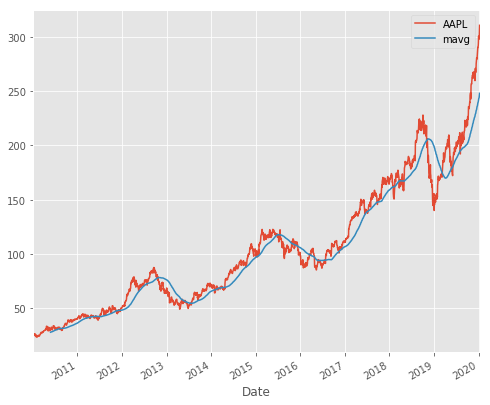

In [4]:
mpl.rc('figure', figsize=(8, 7))

mpl.__version__

# Adjusting the style of matplotlib

style.use('ggplot')

close_px.plot(label='AAPL')

mavg.plot(label='mavg')

plt.legend()

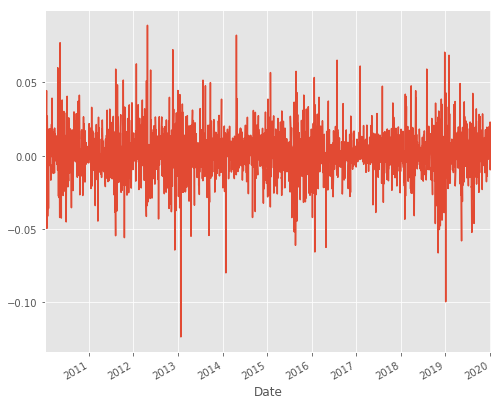

In [5]:
rets = close_px / close_px.shift(1) - 1

rets.plot(label='return')

In [ ]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

In [ ]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()

In [ ]:
plt.scatter(retscomp.AAPL, retscomp.GE)

plt.xlabel('Returns AAPL')

plt.ylabel('Returns GE')

In [ ]:
scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10))

In [ ]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()

plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns)

In [ ]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')

plt.ylabel('Risk')

for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(label,xy = (x, y), xytext = (20, -20),
                 textcoords = 'offset points', ha = 'right', va = 'bottom',
                 bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                 arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [ ]:
dfreg = df.loc[:,['Adj Close','Volume']]

dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0

dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [ ]:
#Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose

forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)

X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = sklearn.preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [ ]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

In [ ]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

In [ ]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

# results

('The linear regression confidence is ', 0.96399641826551985)

('The quadratic regression 2 confidence is ', 0.96492624557970319)

('The quadratic regression 3 confidence is ', 0.9652082834532858)

('The knn regression confidence is ', 0.92844658034790639)

In [ ]:
forecast_set = clf.predict(X_lately)

dfreg['Forecast'] = np.nan

#result

# (array([ 115.44941187,  115.20206522,  116.78688393,  116.70244946,
#         116.58503739,  115.98769407,  116.54315699,  117.40012338,
#         117.21473053,  116.57244657,  116.048717  ,  116.26444966,
#         115.78374093,  116.50647805,  117.92064806,  118.75581186,
#         118.82688731,  119.51873699]), 0.96234891774075604, 18)

In [ ]:
last_date = dfreg.iloc[-1].name

last_unix = last_date

next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:

    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()